# OOS Predictive Performance of SLOPE

## Outline of the steps in this section:
In here, trading strategy with straddles is looked at

- Note cumulative returns for two trading strategies using S&P500 straddles.
    1) Unconditionally selling S&P500 straddles with a constant maturity of 30 days 
        Calculate the returns slightly different: r_shortStraddle = (straddle_t - straddle_t+1)/(0.2 * SP500_t)
        So I need to interpolate a bit different
        Should be substantially positive --> make graph, calculate sharpe ratio, average return and volatility
    2) Conditional strategy using SLOPE as an indicator for whether to buy or sell straddles.
        For 1996 - 1999 training period:
        Compute SLOPE_t using PCA on VIX term structure data from beginning of sample to t
        If SLOPE_t in bottom quintile of historical distribution, buy straddles at t, sell at t+1. Otherwise, short at t, buy             back at t+1
        Should be substantially positive --> make graph, calculate sharpe ratio, average return and volatility
Compare the two strategies, mark in graph where it is different, maybe even a line with the spot price
Play around with the training / test window
What happens when we take another model than PCA?
Exclude Financial crisis? 
Effect Covid?
Own strategy? short 30 day, long 360 day and otherway around? compare sharpe_ratio

In [159]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import sqlalchemy as db
import sys
from scipy.interpolate import interp1d
import os
from datetime import datetime, timedelta
from scipy.stats import norm, skew, kurtosis, shapiro, normaltest, zscore
import math
import matplotlib.dates as mdates
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import kstest_normal
from statsmodels.tsa.stattools import acf

In [160]:
# Import all our data we want to work within this section
#File paths for the CSV files
file_path1 = 'Data/Straddles/short_straddle_returns_correct.csv'
file_path2 = 'Data/Author_Data/STRADDLE_RET.csv'

# Reading the CSV files into Pandas DataFrames
returns_short = pd.read_csv(file_path1)
returns_short['Date'] = pd.to_datetime(returns_short['Date'])

# his given returns include long and short returns (name differ accordingly)
STRADDLE_RET_given = pd.read_csv(file_path2, skiprows=6)
STRADDLE_RET_given['Date'] = pd.to_datetime(STRADDLE_RET_given['Date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
STRADDLE_RET_given['Date'] = pd.to_datetime(STRADDLE_RET_given['Date'])
STRADDLE_RET_given[STRADDLE_RET_given.columns[1:]] = STRADDLE_RET_given[STRADDLE_RET_given.columns[1:]]/100

## Short variance only
First, we calculate the returns for the full period for the unconditional strategy and produce a graph with these returns.

In [161]:
# Calculate cumulative performance starting from 1 at the first date (1996-01-05)
returns_short['cumulative_performance_1'] = (1 + returns_short['r_v_30']).cumprod()
returns_short['cumulative_performance_2'] = (1 + returns_short['r_v_60']).cumprod()
returns_short['cumulative_performance_3'] = (1 + returns_short['r_v_90']).cumprod()
returns_short['cumulative_performance_6'] = (1 + returns_short['r_v_180']).cumprod()
returns_short['cumulative_performance_9'] = (1 + returns_short['r_v_270']).cumprod()
returns_short['cumulative_performance_12'] = (1 + returns_short['r_v_360']).cumprod()

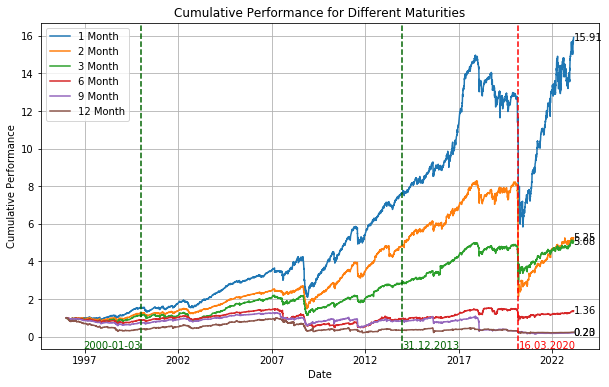

In [162]:
# Plotting the cumulative performances for our data
plt.figure(figsize=(10, 6))
maturity_columns = [1, 2, 3, 6, 9, 12]
# Plot each line for different durations
for mat in maturity_columns:
    plt.plot(returns_short['Date'], returns_short[f'cumulative_performance_{mat}'], label=f'{mat} Month')

    # Add text annotations for the end value of each line
    end_value = returns_short[f'cumulative_performance_{mat}'].iloc[-1]
    plt.text(returns_short['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

years = pd.date_range(start='1996-01-05', end='2022-01-05', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.axvline(pd.to_datetime('2013-12-31'), color='darkgreen', linestyle='--')
plt.text(pd.to_datetime('2013-12-31'), plt.gca().get_ylim()[0], '31.12.2013', color='darkgreen', ha='left')
plt.axvline(pd.to_datetime('2000-01-03'), color='darkgreen', linestyle='--')
plt.text(pd.to_datetime('2000-01-03'), plt.gca().get_ylim()[0], '2000-01-03', color='darkgreen', ha='right')
plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--')
plt.text(pd.to_datetime('2020-03-16'), plt.gca().get_ylim()[0], '16.03.2020', color='red', ha='left')

plt.title('Cumulative Performance for Different Maturities')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.legend()
plt.grid(True)
plt.show()

We do the exact same with his given data to compare it.

In [163]:
# same for his data
STRADDLE_RET_given['cumulative_performance_1'] = (1 + STRADDLE_RET_given['r_1^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_2'] = (1 + STRADDLE_RET_given['r_2^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_3'] = (1 + STRADDLE_RET_given['r_3^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_6'] = (1 + STRADDLE_RET_given['r_6^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_9'] = (1 + STRADDLE_RET_given['r_9^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_12'] = (1 + STRADDLE_RET_given['r_12^{short straddle}']).cumprod()

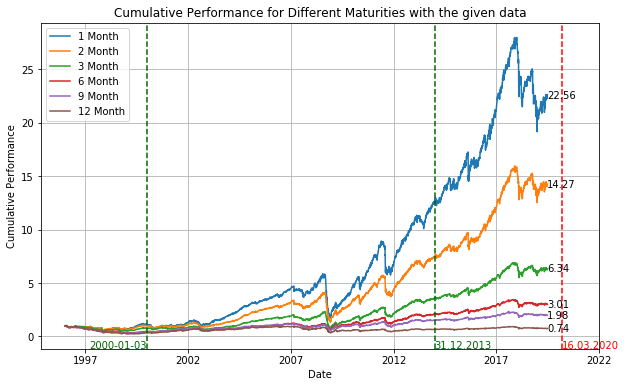

In [164]:
# Plotting the cumulative performances for his data
plt.figure(figsize=(10, 6))
maturity_columns = [1, 2, 3, 6, 9, 12]

# Plot each line for different durations
for mat in maturity_columns:
    plt.plot(STRADDLE_RET_given['Date'], STRADDLE_RET_given[f'cumulative_performance_{mat}'], label=f'{mat} Month')

    # Add text annotations for the end value of each line
    end_value = STRADDLE_RET_given[f'cumulative_performance_{mat}'].iloc[-1]
    plt.text(STRADDLE_RET_given['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

years = pd.date_range(start='1996-01-05', end='2022-01-05', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.axvline(pd.to_datetime('2013-12-31'), color='darkgreen', linestyle='--')
plt.text(pd.to_datetime('2013-12-31'), plt.gca().get_ylim()[0], '31.12.2013', color='darkgreen', ha='left')
plt.axvline(pd.to_datetime('2000-01-03'), color='darkgreen', linestyle='--')
plt.text(pd.to_datetime('2000-01-03'), plt.gca().get_ylim()[0], '2000-01-03', color='darkgreen', ha='right')
plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--')
plt.text(pd.to_datetime('2020-03-16'), plt.gca().get_ylim()[0], '16.03.2020', color='red', ha='left')

plt.title('Cumulative Performance for Different Maturities with the given data')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.legend()
plt.grid(True)
plt.show()
#his dataset is only until 2019

One can clearly see that we are unfortunately need able to replicate his data 1:1. The characteristics, however, look to be the same.
Again, in the paper, the performance graph start at the beginning of 2000 and only leads to end 2013. See the period in darkgreen. To actually compare it though, one would need to recalculate the full performance to start at 1 in the beginning of 2000.

# Now to the conditional performance of the strategy
Conditional strategy using SLOPE as an indicator for whether to buy or sell straddles.
For 1996 - 1999 training period:
Compute SLOPE_t using PCA on VIX term structure data from beginning of sample to t
If SLOPE_t in bottom quintile of historical distribution, buy straddles at t, sell at t+1. Otherwise, short at t, buy             back at t+1. Watch out for the look ahead bias!!!
Should be substantially positive --> make graph, calculate sharpe ratio, average return and volatility
The paper uses a training (in-sample) and testperiod (out-of-sample) for the conditional strategy, and the graph is just from beginning of 2000 to 2013 (even though data would have been available up until 2019).

In this next session, I am only working with the 30 day data. The codes can however just be reused for other maturities

In [165]:
# File paths for the PCA slope data
file_path = 'Data/PCA_custom.csv' #our PCA data
file_path1 = 'Data/Author_Data/PCA.csv' #given PCA data

# Reading the CSV files into Pandas DataFrames and only store the column that is needed for the conditional strategy (Slope)
SLOPE = pd.read_csv(file_path)
SLOPE['Date'] = pd.to_datetime(SLOPE['Date'])

SLOPE_given = pd.read_csv(file_path1,skiprows=12)
SLOPE_given['Date'] = pd.to_datetime(SLOPE_given['Date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')

In [166]:
# Import the returns from the long straddle return
# File paths for the CSV files
file_path2 = 'Data/Straddles/straddle_returns_correct.csv'

# Reading the CSV files into Pandas DataFrames
returns_long = pd.read_csv(file_path2)
returns_long = returns_long.rename(columns={'date': 'Date'})
returns_long['Date'] = pd.to_datetime(returns_long['Date'])


## Option1: Expanding window
Here in the first approach, we compute the quintile based on the historical distribution from expanding the window day-to-day.
We compute the signal based on the condition: True = take the long return (as the current SLOPE value is in the bottom quintile), False = take the short return (as the current SLOPE value is not in the bottom quintile).

In [167]:
# Here, the actual signal is computed
# I get the signal from continously comparing the current value of slope to the historical distribution UP TO t. 
# So in my opinion, there is no need to split up the dataset into training and test data.

# Initialize a list to hold the boolean values for each row
in_bottom_quintile = []

# Calculate quantile based on historical data up until date 't' for each observation
for i in range(len(SLOPE)):
    # Select the data up to the current row's date
    slope_data = SLOPE.loc[SLOPE['Date'] <= SLOPE.iloc[i]['Date']]
    #print(len(slope_data))
    current_value = slope_data.iloc[-1]['Slope']
    #print("Current value: ", current_value)
    historical_values = slope_data.iloc[:-2]['Slope']
    #print("Historical values: ", historical_values)
    quantile = historical_values.quantile(0.2)
    #print('Quantile: ', quantile)
    in_bottom_quintile.append(current_value <= quantile)
     #print(f"True/False_{i}: ", in_bottom_quintile)

# Assign the list to a new column 'InBottomQuintile'
SLOPE['InBottomQuintile'] = in_bottom_quintile

In [168]:
# check how many times the current value is in the bottom quintile
print("    Share of short (false) and long (true) for the bottom quintile")
value_counts = SLOPE['InBottomQuintile'].value_counts()
print(value_counts/sum(value_counts))

    Share of short (false) and long (true) for the bottom quintile
False    0.903877
True     0.096123
Name: InBottomQuintile, dtype: float64


In [169]:
#merge the datasets
returns_long_short_30 = pd.merge(returns_long[['Date', 'return_30']], returns_short[['Date','r_v_30']], on='Date', how='inner')
returns_long_short_30 = returns_long_short_30.merge(SLOPE[['Date', 'InBottomQuintile']], on='Date')
#shift to account for the look ahead bias
returns_long_short_30['InBottomQuintile'] = returns_long_short_30['InBottomQuintile'].shift(1)
returns_long_short_30['InBottomQuintile'][0] = False #set first value manually

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [170]:
# Condition: If the 'InBottomQuintile' is True, use 'return_30' (long return), otherwise 'r_v_30' (short return)
condition = returns_long_short_30.apply(lambda row: row['return_30'] if row['InBottomQuintile'] else row['r_v_30'], axis=1)

# Calculate cumulative returns based on the condition
cumulative_return = (1 + condition).cumprod()
returns_long_short_30['cumulative_returns'] = cumulative_return
returns_long_short_30 # check the result

,Date,return_30,r_v_30,InBottomQuintile,cumulative_returns
0,1996-01-05,-0.047362,0.002855,False,1.002855
1,1996-01-08,-0.050125,0.003020,False,1.005883
2,1996-01-09,0.352578,-0.020640,False,0.985122
3,1996-01-10,0.120899,-0.008543,True,1.104222
4,1996-01-11,-0.096908,0.007298,True,0.997215
...,...,...,...,...,...
6825,2023-02-21,0.074649,-0.007389,False,13.543230
6826,2023-02-22,-0.046649,0.005773,False,13.621416
6827,2023-02-23,-0.043014,0.005049,False,13.690195
6828,2023-02-24,-0.000871,0.000285,False,13.694091


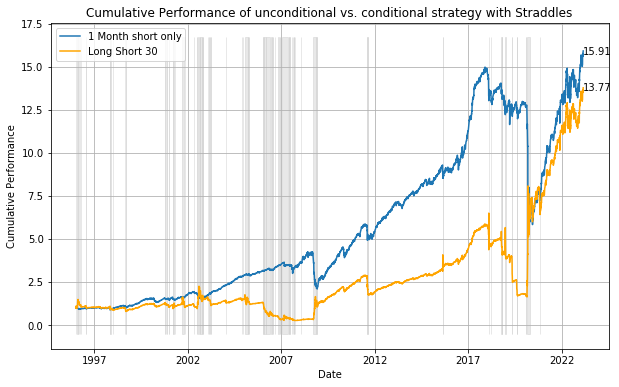

In [171]:
# Plotting the cumulative performances
plt.figure(figsize=(10, 6))

# Plot the cumulative distribution for the unconditional short straddle strategy as a benchmark
plt.plot(returns_short['Date'], returns_short['cumulative_performance_1'], label='1 Month short only')
# Add text annotations for the end value of each line
end_value = returns_short['cumulative_performance_1'].iloc[-1]
plt.text(returns_short['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Add the cumulative returns from the conditional strategy
plt.plot(returns_long_short_30['Date'], returns_long_short_30['cumulative_returns'], color='orange', label='Long Short 30')
# Add text annotations for the end value of each line
end_value = returns_long_short_30['cumulative_returns'].iloc[-1]
plt.text(returns_long_short_30['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Shade the region where 'InBottomQuantile' is True, so where the two strategies differ
plt.fill_between(returns_long_short_30['Date'], plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], 
                 where=returns_long_short_30['InBottomQuintile'], color='lightgrey', alpha=0.5)

#some formatting
years = pd.date_range(start='1996-01-05', end='2023-02-27', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.title('Cumulative Performance of unconditional vs. conditional strategy with Straddles')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.legend()
plt.grid(True)
# Show the modified plot
plt.show()

This actually does not look comparable to the results he gets.
This needs to be further investigated.
A first idea is to not use the bottom quintile, but compute it with a grid, going from the 0.05 quantile to the 0.2 quantile.

## Try different quantiles
It looks like the strategy with the bottom quintile as the condition is long too often. An idea is the lower this condition so a lower value is taken.

In [172]:
# copy the SLOPE dataset
SLOPE1 = SLOPE.copy()
SLOPE1 = SLOPE1.drop(columns='InBottomQuintile') #delete the InBottomQuantile column
# Quantiles to calculate
quantiles = [0.05, 0.1, 0.15, 0.2]

# Loop through quantiles
for q in quantiles:
    # Initialize a list to hold the boolean values for each row for the current quantile
    in_bottom_quantile = []

    # Calculate quantile based on historical data up until date 't' for each observation
    for i in range(len(SLOPE1)):
        # Select the data up to the current row's date
        slope_data = SLOPE1.loc[SLOPE1['Date'] <= SLOPE1.iloc[i]['Date']]
        current_value = slope_data.iloc[-1]['Slope']
        historical_values = slope_data.iloc[:-2]['Slope']
        quantile_value = historical_values.quantile(q)
        in_bottom_quantile.append(current_value <= quantile_value)
        
    # Assign the list to a new column with a descriptive name
    SLOPE1[f'InBottomQuantile_{q}'] = in_bottom_quantile
# Display the modified DataFrame
print(SLOPE1) # check the results

           Date     Slope  InBottomQuantile_0.05  InBottomQuantile_0.1  \
0    1996-01-04 -1.045535                  False                 False   
1    1996-01-05 -0.985268                  False                 False   
2    1996-01-08 -1.009860                  False                 False   
3    1996-01-09 -1.187096                   True                  True   
4    1996-01-10 -1.159396                   True                  True   
...         ...       ...                    ...                   ...   
6830 2023-02-22 -0.133776                  False                 False   
6831 2023-02-23 -0.106842                  False                 False   
6832 2023-02-24 -0.077891                  False                 False   
6833 2023-02-27 -0.105548                  False                 False   
6834 2023-02-28 -0.126904                  False                 False   

      InBottomQuantile_0.15  InBottomQuantile_0.2  
0                     False                 False  
1      

In [173]:
# get some statistics to see the difference!
# check how many times the current value is in the bottom quintile
print("    Share of short (false) and long (true) for the 0.05-quantile")
value_counts = SLOPE1[f'InBottomQuantile_{0.05}'].value_counts()
print(value_counts/sum(value_counts))

print("    Share of short (false) and long (true) for the 0.1-quantile")
value_counts = SLOPE1[f'InBottomQuantile_{0.1}'].value_counts()
print(value_counts/sum(value_counts))

print("    Share of short (false) and long (true) for the 0.15-quantile")
value_counts = SLOPE1[f'InBottomQuantile_{0.15}'].value_counts()
print(value_counts/sum(value_counts))

print("    Share of short (false) and long (true) for the 0.2-quantile")
value_counts = SLOPE1[f'InBottomQuantile_{0.2}'].value_counts()
print(value_counts/sum(value_counts))

    Share of short (false) and long (true) for the 0.05-quantile
False    0.96752
True     0.03248
Name: InBottomQuantile_0.05, dtype: float64
    Share of short (false) and long (true) for the 0.1-quantile
False    0.950402
True     0.049598
Name: InBottomQuantile_0.1, dtype: float64
    Share of short (false) and long (true) for the 0.15-quantile
False    0.925823
True     0.074177
Name: InBottomQuantile_0.15, dtype: float64
    Share of short (false) and long (true) for the 0.2-quantile
False    0.903877
True     0.096123
Name: InBottomQuantile_0.2, dtype: float64


In [174]:
#merge the datasets
returns_long_short_30_1 = pd.merge(returns_long[['Date', 'return_30']], returns_short[['Date','r_v_30']], on='Date', how='inner')
returns_long_short_30_1 = returns_long_short_30_1.merge(SLOPE1[['Date', 'InBottomQuantile_0.05',
                                                          'InBottomQuantile_0.1', 'InBottomQuantile_0.15',
                                                          'InBottomQuantile_0.2']], on='Date')
#shift to account for the look ahead bias
returns_long_short_30_1[['InBottomQuantile_0.05', 'InBottomQuantile_0.1', 'InBottomQuantile_0.15', 'InBottomQuantile_0.2']] = returns_long_short_30_1[['InBottomQuantile_0.05', 'InBottomQuantile_0.1', 'InBottomQuantile_0.15', 'InBottomQuantile_0.2']].shift(1)
returns_long_short_30_1.loc[0, ['InBottomQuantile_0.05', 'InBottomQuantile_0.1', 'InBottomQuantile_0.15', 'InBottomQuantile_0.2']] = False

In [175]:
quantiles = ['0.05', '0.1', '0.15', '0.2']

for quantile in quantiles:
    condition_col = f'InBottomQuantile_{quantile}'
    return_long = f'return_30'
    return_short = f'r_v_30'

    # Condition: If the current quantile column is True, use the 'return_30' (long return) column, otherwise 'r_v_30' (short return)
    condition = returns_long_short_30_1.apply(lambda row: row[return_long] if row[condition_col] else row[return_short], axis=1)

    # Calculate cumulative returns based on the condition
    cumulative_return = (1 + condition).cumprod()
    returns_long_short_30_1[f'cumulative_returns_{quantile}'] = cumulative_return

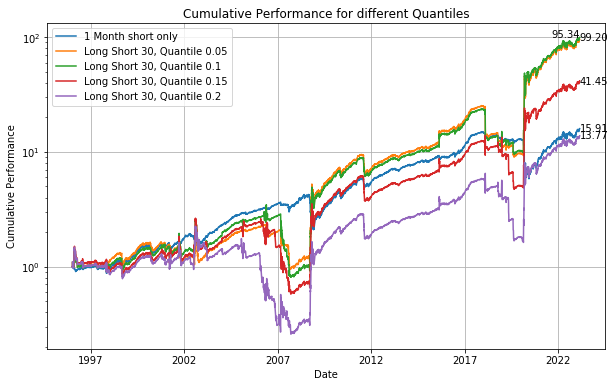

In [176]:
# Plotting the cumulative performances
plt.figure(figsize=(10, 6))
# Plot the short only cumulative performance
plt.plot(returns_short['Date'], returns_short['cumulative_performance_1'], label='1 Month short only')
# Add text annotations for the end value of each line
end_value = returns_short['cumulative_performance_1'].iloc[-1]
plt.text(returns_short['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Plot line for different quantiles
quantiles = ['0.05', '0.1', '0.15', '0.2']
for quantile in quantiles:
    cumulative_col = f'cumulative_returns_{quantile}'
    plt.plot(returns_long_short_30_1['Date'], returns_long_short_30_1[cumulative_col], label=f'Long Short 30, Quantile {quantile}')

    # Add text annotations for the end value of each line
    end_value = returns_long_short_30_1[cumulative_col].iloc[-1]
    if quantile == '0.05':
        plt.text(returns_long_short_30_1['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='bottom', ha='right')
    else:
        plt.text(returns_long_short_30_1['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

years = pd.date_range(start='1996-01-05', end='2023-02-27', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.title('Cumulative Performance for different Quantiles')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.yscale('log')  # Set the y-axis to log scale
plt.legend()
plt.grid(True)

# Show the modified plot
plt.show()

For fun: check at which quantile the maximum performance would be reached.

In [203]:
# Quantiles to evaluate
quantiles_to_evaluate = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]

# Create a DataFrame to store the results
results_df = pd.DataFrame(index=quantiles_to_evaluate, columns=['Cumulative_Returns'])
# Copy the original DataFrame to avoid modifying the original data
returns_long_short_30_copy = returns_long_short_30_1.copy()[["Date", "return_30", "r_v_30"]]
# Loop through quantiles
for q in quantiles_to_evaluate:
    # Initialize a list to hold the boolean values for each row for the current quantile
    in_bottom_quantile = []

    # Calculate quantile based on historical data up until date 't' for each observation
    for i in range(len(returns_long_short_30_copy)):
        # Select the data up to the current row's date
        slope_data = SLOPE1.loc[SLOPE1['Date'] <= SLOPE1.iloc[i]['Date']]
        current_value = slope_data.iloc[-1]['Slope']
        historical_values = slope_data.iloc[:-2]['Slope']
        quantile_value = historical_values.quantile(q)
        in_bottom_quantile.append(current_value <= quantile_value)
        
    # Assign the list to a new column
    returns_long_short_30_copy[f'InBottomQuantile_{q}'] = in_bottom_quantile

    # Shift to account for the look ahead bias
    returns_long_short_30_copy[f'InBottomQuantile_{q}'] = returns_long_short_30_copy[f'InBottomQuantile_{q}'].shift(1)
    returns_long_short_30_copy.loc[0, f'InBottomQuantile_{q}'] = False

    # Calculate cumulative returns based on the condition
    cumulative_return = (1 + returns_long_short_30_copy.apply(lambda row: row['return_30'] if row[f'InBottomQuantile_{q}'] else row['r_v_30'], axis=1)).cumprod().iloc[-1]

    # Store the results in the DataFrame
    results_df.at[q, 'Cumulative_Returns'] = cumulative_return


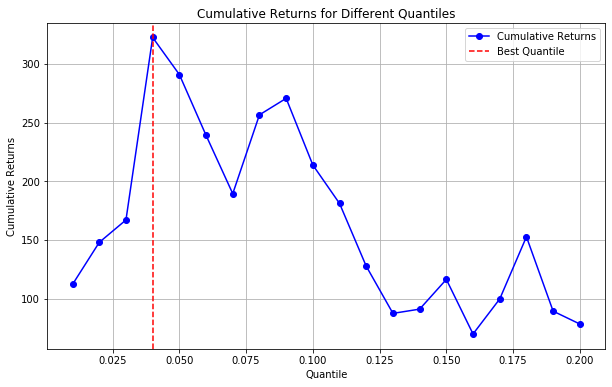

Best quantile to use: 0.04


In [204]:
# Find the quantile with the maximum cumulative returns
max_return = results_df['Cumulative_Returns'].max()
best_quantile = results_df.loc[results_df['Cumulative_Returns'] == max_return].index[0]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['Cumulative_Returns'], marker='o', linestyle='-', color='blue', label='Cumulative Returns')
plt.axvline(x=best_quantile, color='red', linestyle='--', label='Best Quantile')

# Customize the plot
plt.title('Cumulative Returns for Different Quantiles')
plt.xlabel('Quantile')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

print(f"Best quantile to use: {best_quantile}")

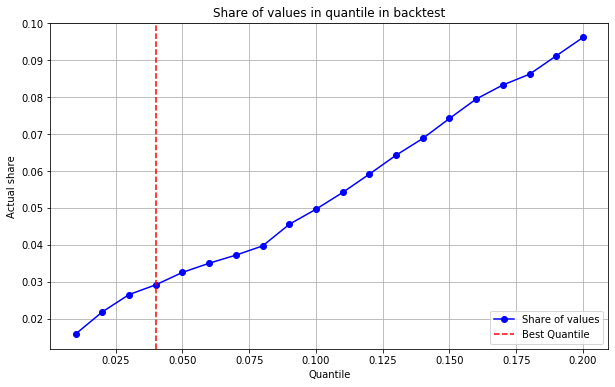

In [207]:
# Calculate the share of True values per quantile and store in 'True_Share' column
results_df['True_Share'] = [returns_long_short_30_copy[f'InBottomQuantile_{q}'].mean() for q in quantiles_to_evaluate]
# Find the quantile with the maximum cumulative returns
max_return = results_df['Cumulative_Returns'].max()
best_quantile = results_df.loc[results_df['Cumulative_Returns'] == max_return].index[0]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['True_Share'], marker='o', linestyle='-', color='blue', label='Share of values')
plt.axvline(x=best_quantile, color='red', linestyle='--', label='Best Quantile')

# Customize the plot
plt.title('Share of values in quantile in backtest')
plt.xlabel('Quantile')
plt.ylabel('Actual share')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## Comparison to his data
Data import has been done above in the introduction.

In [179]:
# modify the dataframe
SLOPE_given = SLOPE_given[['Date', 'PC2']]

# Rename 'PC2' to 'Slope'
SLOPE_given = SLOPE_given.rename(columns={'PC2': 'Slope'})
#SLOPE_given

In [180]:
# Initialize a list to hold the boolean values for each row
in_bottom_quintile = []

# Calculate quantile based on historical data up until date 't' for each observation
for i in range(len(SLOPE_given)):
    # Select the data up to the current row's date
    slope_data = SLOPE_given.loc[SLOPE_given['Date'] <= SLOPE_given.iloc[i]['Date']]
    #print(i)
    #print("Slope: ",slope_data)
    current_value = slope_data.iloc[-1]['Slope']
    #print("Current value: ", current_value)
    historical_values = slope_data.iloc[:-2]['Slope']
    #print("Historical values: ", historical_values)
    quantile = historical_values.quantile(0.2)
    #print('Quantile: ', quantile)
    in_bottom_quintile.append(current_value <= quantile)
    #print(f"True/False_{i}: ", in_bottom_quintile)

# Assign the list to a new column 'InBottomQuintile'
SLOPE_given['InBottomQuintile'] = in_bottom_quintile

In [181]:
# check how many times the current value is in the bottom quintile
print("    Share of short (false) and long (true) for the bottom quintile")
value_counts = SLOPE_given['InBottomQuintile'].value_counts()
print(value_counts/sum(value_counts))

    Share of short (false) and long (true) for the bottom quintile
False    0.910352
True     0.089648
Name: InBottomQuintile, dtype: float64


In [182]:
# merge the datasets
SLOPE_given['Date'] = pd.to_datetime(SLOPE_given['Date'])
returns_long_short_30_2 = STRADDLE_RET_given[['Date', 'r_1^{straddle}', 'r_1^{short straddle}']]
returns_long_short_30_2 = returns_long_short_30_2.merge(SLOPE_given[['Date', 'InBottomQuintile']], on='Date')
#shift to account for the look ahead bias
returns_long_short_30_2['InBottomQuintile'] = returns_long_short_30_2['InBottomQuintile'].shift(1)
returns_long_short_30_2['InBottomQuintile'][0] = False #set first value manually
#print(returns_long_short_30)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [183]:
# Condition: If the 'condition_column' is True, use 'return_30', otherwise 'r_v_30'
condition = returns_long_short_30_2.apply(lambda row: row['r_1^{straddle}'] if row['InBottomQuintile'] else row['r_1^{short straddle}'], axis=1)
# Calculate cumulative returns based on the condition
cumulative_return = (1 + condition).cumprod()
returns_long_short_30_2['cumulative_returns'] = cumulative_return
#returns_long_short_30

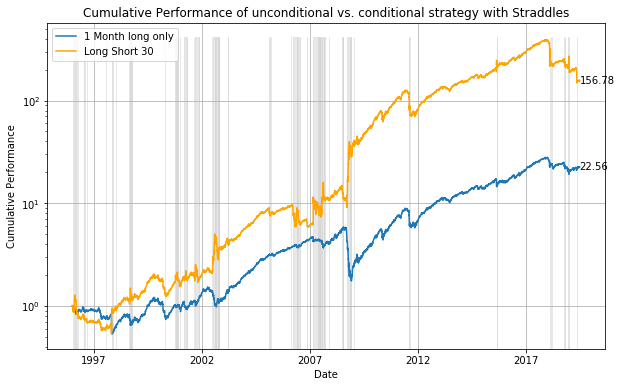

In [184]:
# Plotting the cumulative performances
#this is not finished yet and still needs some working!
plt.figure(figsize=(10, 6))

# Plot short only
plt.plot(STRADDLE_RET_given['Date'], STRADDLE_RET_given['cumulative_performance_1'], label=f'1 Month long only')
# Add text annotations for the end value of each line
end_value = STRADDLE_RET_given['cumulative_performance_1'].iloc[-1]
plt.text(STRADDLE_RET_given['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Add the line from the conditional strategy
plt.plot(returns_long_short_30_2['Date'], returns_long_short_30_2['cumulative_returns'], color='orange', label='Long Short 30')
# Add text annotations for the end value of each line
end_value = returns_long_short_30_2['cumulative_returns'].iloc[-1]
plt.text(returns_long_short_30_2['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Shade the region where 'InBottomQuantile' is True
plt.fill_between(returns_long_short_30_2['Date'], plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], 
                 where=returns_long_short_30_2['InBottomQuintile'], color='lightgrey', alpha=0.5)

years = pd.date_range(start='1996-01-05', end='2019-12-31', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.title('Cumulative Performance of unconditional vs. conditional strategy with Straddles')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.yscale('log')  # Set the y-axis to log scale
plt.legend()
plt.grid(True)
# Show the modified plot
plt.show()

The differences differ a lot, even though the code that is applied is the exact same. This must be because of the differences in the data! Check how the returns look like with his PCA data.

In [187]:
returns_long_short_30_2

,Date,r_1^{straddle},r_1^{short straddle},InBottomQuintile,cumulative_returns
0,1996-01-05,-0.04067,0.00500,False,1.005000
1,1996-01-08,-0.01795,0.00224,False,1.007251
2,1996-01-09,0.34233,-0.04098,False,0.965974
3,1996-01-10,0.00968,-0.00139,True,0.975325
4,1996-01-11,-0.09191,0.01410,True,0.885683
...,...,...,...,...,...
5906,2019-06-24,-0.05374,0.00788,False,155.796255
5907,2019-06-25,0.02155,-0.00323,False,155.293033
5908,2019-06-26,-0.03581,0.00578,False,156.190627
5909,2019-06-27,-0.01815,0.00292,False,156.646704


In [208]:
# lets check the best quantiles for his data
# Quantiles to evaluate
quantiles_to_evaluate = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]

# Create a DataFrame to store the results
results_df1 = pd.DataFrame(index=quantiles_to_evaluate, columns=['Cumulative_Returns'])
# Copy the original DataFrame to avoid modifying the original data
returns_long_short_30_2_copy = returns_long_short_30_2.copy()[["Date", "r_1^{straddle}", "r_1^{short straddle}"]]

# Loop through quantiles
for q in quantiles_to_evaluate:
    # Initialize a list to hold the boolean values for each row for the current quantile
    in_bottom_quantile = []

    # Calculate quantile based on historical data up until date 't' for each observation
    for i in range(len(returns_long_short_30_2_copy)):
        # Select the data up to the current row's date
        slope_data = SLOPE_given.loc[SLOPE_given['Date'] <= SLOPE_given.iloc[i]['Date']]
        current_value = slope_data.iloc[-1]['Slope']
        historical_values = slope_data.iloc[:-2]['Slope']
        quantile_value = historical_values.quantile(q)
        in_bottom_quantile.append(current_value <= quantile_value)
        
    # Assign the list to a new column
    returns_long_short_30_2_copy[f'InBottomQuantile_{q}'] = in_bottom_quantile

    # Shift to account for the look ahead bias
    returns_long_short_30_2_copy[f'InBottomQuantile_{q}'] = returns_long_short_30_2_copy[f'InBottomQuantile_{q}'].shift(1)
    returns_long_short_30_2_copy.loc[0, f'InBottomQuantile_{q}'] = False

    # Calculate cumulative returns based on the condition
    cumulative_return = (1 + returns_long_short_30_2_copy.apply(lambda row: row['r_1^{straddle}'] if row[f'InBottomQuantile_{q}'] else row['r_1^{short straddle}'], axis=1)).cumprod().iloc[-1]

    # Store the results in the DataFrame
    results_df1.at[q, 'Cumulative_Returns'] = cumulative_return


In [209]:
returns_long_short_30_2_copy

,Date,r_1^{straddle},r_1^{short straddle},InBottomQuantile_0.01,InBottomQuantile_0.02,InBottomQuantile_0.03,InBottomQuantile_0.04,InBottomQuantile_0.05,InBottomQuantile_0.06,InBottomQuantile_0.07,...,InBottomQuantile_0.11,InBottomQuantile_0.12,InBottomQuantile_0.13,InBottomQuantile_0.14,InBottomQuantile_0.15,InBottomQuantile_0.16,InBottomQuantile_0.17,InBottomQuantile_0.18,InBottomQuantile_0.19,InBottomQuantile_0.2
0,1996-01-05,-0.04067,0.00500,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1996-01-08,-0.01795,0.00224,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1996-01-09,0.34233,-0.04098,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1996-01-10,0.00968,-0.00139,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1996-01-11,-0.09191,0.01410,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5906,2019-06-24,-0.05374,0.00788,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5907,2019-06-25,0.02155,-0.00323,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5908,2019-06-26,-0.03581,0.00578,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5909,2019-06-27,-0.01815,0.00292,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


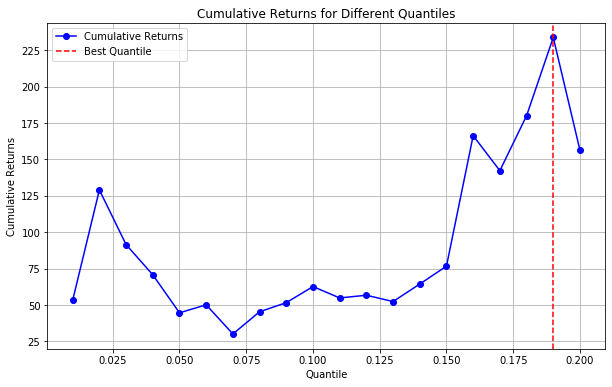

Best quantile to use: 0.19


In [210]:
# Find the quantile with the maximum cumulative returns
max_return = results_df1['Cumulative_Returns'].max()
best_quantile = results_df1.loc[results_df1['Cumulative_Returns'] == max_return].index[0]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results_df1.index, results_df1['Cumulative_Returns'], marker='o', linestyle='-', color='blue', label='Cumulative Returns')
plt.axvline(x=best_quantile, color='red', linestyle='--', label='Best Quantile')

# Customize the plot
plt.title('Cumulative Returns for Different Quantiles')
plt.xlabel('Quantile')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

print(f"Best quantile to use: {best_quantile}")

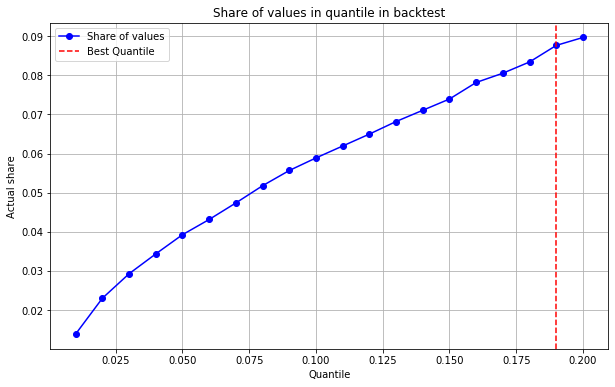

In [212]:
# Calculate the share of True values per quantile and store in 'True_Share' column
results_df1['True_Share'] = [returns_long_short_30_2_copy[f'InBottomQuantile_{q}'].mean() for q in quantiles_to_evaluate]
# Find the quantile with the maximum cumulative returns
max_return = results_df1['Cumulative_Returns'].max()
best_quantile = results_df1.loc[results_df1['Cumulative_Returns'] == max_return].index[0]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results_df1.index, results_df1['True_Share'], marker='o', linestyle='-', color='blue', label='Share of values')
plt.axvline(x=best_quantile, color='red', linestyle='--', label='Best Quantile')

# Customize the plot
plt.title('Share of values in quantile in backtest')
plt.xlabel('Quantile')
plt.ylabel('Actual share')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# TEST: His PCA with our returns

In [27]:
#merge the datasets
SLOPE_given['Date'] = pd.to_datetime(SLOPE_given['Date'])
returns_long_short_30_3 = pd.merge(returns_long[['Date', 'return_30']], returns_short[['Date','r_v_30']], on='Date', how='inner')
returns_long_short_30_3 = returns_long_short_30_3.merge(SLOPE_given[['Date', 'InBottomQuintile']], on='Date')
#shift to account for the look ahead bias
returns_long_short_30_3['InBottomQuintile'] = returns_long_short_30_3['InBottomQuintile'].shift(1)
returns_long_short_30_3['InBottomQuintile'][0] = False #set first value manually
# Condition: If the 'condition_column' is True, use 'return_30', otherwise 'r_v_30'
condition = returns_long_short_30_3.apply(lambda row: row['return_30'] if row['InBottomQuintile'] else row['r_v_30'], axis=1)
# Calculate cumulative returns based on the condition
cumulative_return = (1 + condition).cumprod()
returns_long_short_30_3['cumulative_returns'] = cumulative_return

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


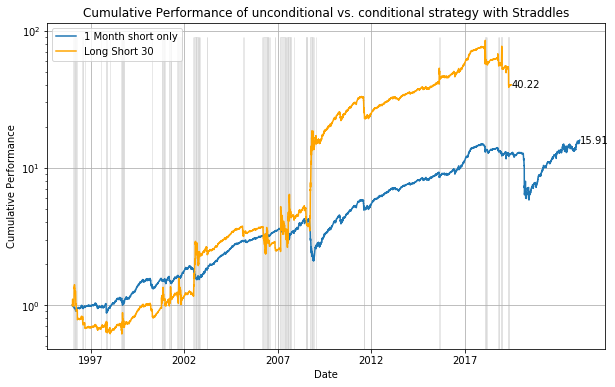

In [28]:
# Plotting the cumulative performances
plt.figure(figsize=(10, 6))

# Plot unconditional strategy for the benchmark (coming from our data)
plt.plot(returns_short['Date'], returns_short['cumulative_performance_1'], label='1 Month short only')
# Add text annotations for the end value of each line
end_value = returns_short['cumulative_performance_1'].iloc[-1]
plt.text(returns_short['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Add the line from the conditional strategy
plt.plot(returns_long_short_30_3['Date'], returns_long_short_30_3['cumulative_returns'], color='orange', label='Long Short 30')
# Add text annotations for the end value of each line
end_value = returns_long_short_30_3['cumulative_returns'].iloc[-1]
plt.text(returns_long_short_30_3['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Shade the region where 'InBottomQuantile' is True
plt.fill_between(returns_long_short_30_3['Date'], plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], 
                 where=returns_long_short_30_3['InBottomQuintile'], color='lightgrey', alpha=0.5)

# some formatting
years = pd.date_range(start='1996-01-05', end='2019-12-31', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.title('Cumulative Performance of unconditional vs. conditional strategy with Straddles')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.yscale('log')  # Set the y-axis to log scale
plt.legend()
plt.grid(True)
# Show the modified plot
plt.show()

# Option 2: Split the data in training and test data
Instead of getting the condition based on the expanding time window, we could also split the data into training and test sets. The training set is used to calculate the quintile. Then, the test data is comparing the current slope value to this quintile. If it is in the lower quintile, we take the long return, if it is not, we take the short return.

In [29]:
# Split the data into training and test sets
training_data = SLOPE[SLOPE['Date'] <= '2002-12-31'].copy()
test_data = SLOPE[SLOPE['Date'] > '2002-12-31'].copy()

# Calculate quantile based on historical distribution of the training data
quantile_train = training_data['Slope'].quantile(0.2)

# Assign the boolean values to the test data based on the calculated quantile
test_data['InBottomQuintile'] = test_data['Slope'].copy() <= quantile_train

In [30]:
print("    Share of short (false) and long (true) for the bottom quintile")
value_counts = test_data['InBottomQuintile'].value_counts()
print(value_counts/sum(value_counts))

    Share of short (false) and long (true) for the bottom quintile
False    0.918013
True     0.081987
Name: InBottomQuintile, dtype: float64


In [31]:
#merge the datasets
returns_long_short_30_4 = pd.merge(returns_long[['Date', 'return_30']], returns_short[['Date','r_v_30']], on='Date', how='inner')
returns_long_short_30_4 = returns_long_short_30_4.merge(test_data[['Date', 'InBottomQuintile']], on='Date')
#shift to account for the look ahead bias
returns_long_short_30_4['InBottomQuintile'] = returns_long_short_30_4['InBottomQuintile'].shift(1)
returns_long_short_30_4['InBottomQuintile'][0] = True #set first value manually

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
# Condition: If the 'condition_column' is True, use 'return_30', otherwise 'r_v_30'
condition = returns_long_short_30_4.apply(lambda row: row['return_30'] if row['InBottomQuintile'] else row['r_v_30'], axis=1)
# Calculate cumulative returns based on the condition
cumulative_return = (1 + condition).cumprod()
returns_long_short_30_4['cumulative_returns'] = cumulative_return
#returns_long_short_30

In [33]:
# to be able to compare it to the short only strategy, we have to recalculate the short only cumulative returns
returns_short_test = returns_long_short_30_4[['Date', 'r_v_30']].copy()
returns_short_test['cumulative_performance'] = (1 + returns_short_test['r_v_30']).cumprod()

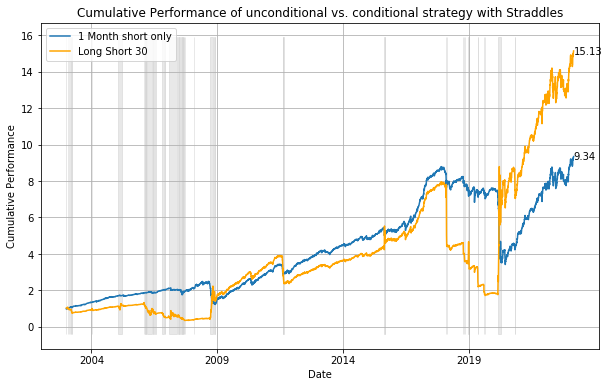

In [34]:
# Plotting the cumulative performances
#this is not finished yet and still needs some working!
plt.figure(figsize=(10, 6))

# Plot each line for different durations
plt.plot(returns_short_test['Date'], returns_short_test['cumulative_performance'], label='1 Month short only')
# Add text annotations for the end value of each line
end_value = returns_short_test['cumulative_performance'].iloc[-1]
plt.text(returns_short_test['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Add the line from 'returns_long_short_30'
plt.plot(returns_long_short_30_4['Date'], returns_long_short_30_4['cumulative_returns'], color='orange', label='Long Short 30')
# Add text annotations for the end value of each line
end_value = returns_long_short_30_4['cumulative_returns'].iloc[-1]
plt.text(returns_long_short_30_4['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Shade the region where 'InBottomQuantile' is True
plt.fill_between(returns_long_short_30_4['Date'], plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], 
                 where=returns_long_short_30_4['InBottomQuintile'], color='lightgrey', alpha=0.5)

#STRADDLE_RET_given['Date'] = pd.to_datetime(STRADDLE_RET_given['Date'])
years = pd.date_range(start='2003-01-05', end='2022-12-31', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.title('Cumulative Performance of unconditional vs. conditional strategy with Straddles')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.legend()
plt.grid(True)
# Show the modified plot
plt.show()

# Trying to find out why the results differ so much for the two PCA datasets

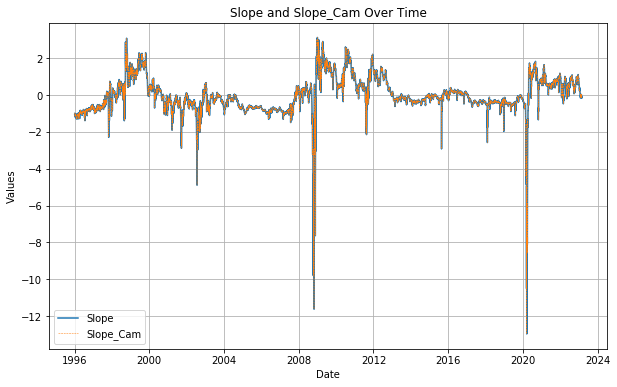

In [35]:
# File paths for the PCA slope data
file_path = 'Data/OUR_PCA.csv'

# Reading the CSV files into Pandas DataFrames and only store the column that is needed for the conditional strategy (Slope)
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Plotting
plt.figure(figsize=(10, 6))

# Plot 'Slope'
plt.plot(df['Date'], df['Slope'], label='Slope', linestyle = '-')

# Plot 'Slope_Cam'
plt.plot(df['Date'], df['Slope_Cam'], label='Slope_Cam', linestyle = '--', linewidth=0.5)

# Customize the plot
plt.title('Slope and Slope_Cam Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [36]:
print('Variance Cam: ', df['Slope_Cam'].var())
print('Variance Julius: ', df['Slope'].var())
print('Mean Cam: ', df['Slope_Cam'].mean())
print('Mean Julius: ', df['Slope'].mean())
print('Quantiles Julius: ', df['Slope'].quantile([0.2, 0.4, 0.6, 0.8]))
print('Quantiles Cam: ', df['Slope_Cam'].quantile([0.2, 0.4, 0.6, 0.8]))
print('Correlation: ', df['Slope'].corr(df['Slope_Cam']))

Variance Cam:  1.0001463271600946
Variance Julius:  1.0001463271543092
Mean Cam:  4.2075190523424754e-12
Mean Julius:  1.1558444870161423e-11
Quantiles Julius:  0.2   -0.645490
0.4   -0.300520
0.6    0.062660
0.8    0.690226
Name: Slope, dtype: float64
Quantiles Cam:  0.2   -0.645490
0.4   -0.300520
0.6    0.062660
0.8    0.690226
Name: Slope_Cam, dtype: float64
Correlation:  1.0


In [37]:
max_value = returns_long_short_30_3['return_30'].max()
best_row = returns_long_short_30_3.loc[returns_long_short_30_3['return_30'] == max_value]
print('Biggest long return our data:')
print(best_row[['Date', 'return_30', 'r_v_30']])
max_value = returns_long_short_30_3['r_v_30'].max()
best_row = returns_long_short_30_3.loc[returns_long_short_30_3['r_v_30'] == max_value]
print('Biggest short return our data (3):')
print(best_row[['Date', 'return_30', 'r_v_30']])

print(returns_long_short_30['return_30'].max())
max_value = returns_long_short_30['r_v_30'].max()
best_row = returns_long_short_30.loc[returns_long_short_30['r_v_30'] == max_value]
print('Biggest short return our data (1):')
print(best_row[['Date', 'return_30', 'r_v_30']])
print(returns_long_short_30_1['r_v_30'].max())
print(best_row)

max_value = returns_long_short_30_2['r_1^{straddle}'].max()
best_row = returns_long_short_30_2.loc[returns_long_short_30_2['r_1^{straddle}'] == max_value]
print('Biggest long return his data:')
print(best_row[['Date', 'r_1^{straddle}', 'r_1^{short straddle}']])
max_value = returns_long_short_30_2['r_1^{short straddle}'].max()
best_row = returns_long_short_30_2.loc[returns_long_short_30_2['r_1^{short straddle}'] == max_value]
print('Biggest short return his data:')
print(best_row[['Date', 'r_1^{straddle}', 'r_1^{short straddle}']])
print(best_row)

Biggest long return our data:
           Date  return_30    r_v_30
2801 2007-02-27   1.114533 -0.060919
Biggest short return our data (3):
           Date  return_30    r_v_30
2917 2007-08-13  -0.109621  0.101376
1.114532762638977
Biggest short return our data (1):
           Date  return_30    r_v_30
6096 2020-03-30  -0.113942  0.109433
0.1094327204732478
           Date  return_30    r_v_30 InBottomQuintile  cumulative_returns
6096 2020-03-30  -0.113942  0.109433             True            6.774377
Biggest long return his data:
           Date  r_1^{straddle}  r_1^{short straddle}
2804 2007-02-27         0.86382              -0.10319
Biggest short return his data:
           Date  r_1^{straddle}  r_1^{short straddle}
3220 2008-10-20        -0.12685               0.08977
           Date  r_1^{straddle}  r_1^{short straddle} InBottomQuintile  \
3220 2008-10-20        -0.12685               0.08977             True   

      cumulative_returns  
3220           27.176995  


In [38]:
# compare the true/false values of the different dataset, where are they different? How many times?
# what were the returns on those days? 
# his data: returns_long_short_30_2
# our data (full): returns_long_short_30_1
compare_InBottomQuintiles = pd.merge(returns_long_short_30[['Date', 'return_30', 'r_v_30', 'InBottomQuintile']], returns_long_short_30_2[['Date','r_1^{straddle}', 'r_1^{short straddle}', 'InBottomQuintile']], on='Date', how='inner')
compare_InBottomQuintiles = compare_InBottomQuintiles.rename(columns={'InBottomQuintile_x': 'our_condition'})
compare_InBottomQuintiles = compare_InBottomQuintiles.rename(columns={'InBottomQuintile_y': 'his_condition'})
print(compare_InBottomQuintiles)


           Date  return_30    r_v_30 our_condition  r_1^{straddle}  \
0    1996-01-05  -0.047362  0.002855         False        -0.04067   
1    1996-01-08  -0.050125  0.003020         False        -0.01795   
2    1996-01-09   0.352578 -0.020640         False         0.34233   
3    1996-01-10   0.120899 -0.008543          True         0.00968   
4    1996-01-11  -0.096908  0.007298          True        -0.09191   
...         ...        ...       ...           ...             ...   
5903 2019-06-24  -0.053542  0.003957         False        -0.05374   
5904 2019-06-25   0.020247 -0.001429         False         0.02155   
5905 2019-06-26  -0.035831  0.002890         False        -0.03581   
5906 2019-06-27  -0.016247  0.001278         False        -0.01815   
5907 2019-06-28  -0.003772  0.000288         False        -0.00534   

      r_1^{short straddle} his_condition  
0                  0.00500         False  
1                  0.00224         False  
2                 -0.04098    

In [39]:
unequal_conditions = compare_InBottomQuintiles[compare_InBottomQuintiles['our_condition'] != compare_InBottomQuintiles['his_condition']]

# Printing the filtered DataFrame
print(unequal_conditions)
print(len(unequal_conditions))
print(len(unequal_conditions)/len(compare_InBottomQuintiles))

           Date  return_30    r_v_30 our_condition  r_1^{straddle}  \
5    1996-01-12  -0.014053  0.000916          True        -0.01134   
18   1996-01-31   0.099649 -0.005713          True         0.12568   
19   1996-02-01   0.010408 -0.000599          True         0.02960   
26   1996-02-12   0.044192 -0.003143         False         0.06358   
36   1996-02-27  -0.017076  0.001318         False        -0.02093   
...         ...        ...       ...           ...             ...   
5589 2018-03-23   0.058447 -0.006180         False         0.05347   
5590 2018-03-26   0.043600 -0.004410          True         0.04240   
5731 2018-10-15  -0.076132  0.007571          True        -0.07562   
5875 2019-05-14  -0.063863  0.005598          True        -0.05363   
5876 2019-05-15  -0.066253  0.006129          True        -0.06390   

      r_1^{short straddle} his_condition  
5                  0.00152         False  
18                -0.01477         False  
19                -0.00344    

So, when comparing his signals to ours, they differ ~5% of the times.
Test the distributions of the straddle returns. Return distribution of the long returns and short returns vs his returns.

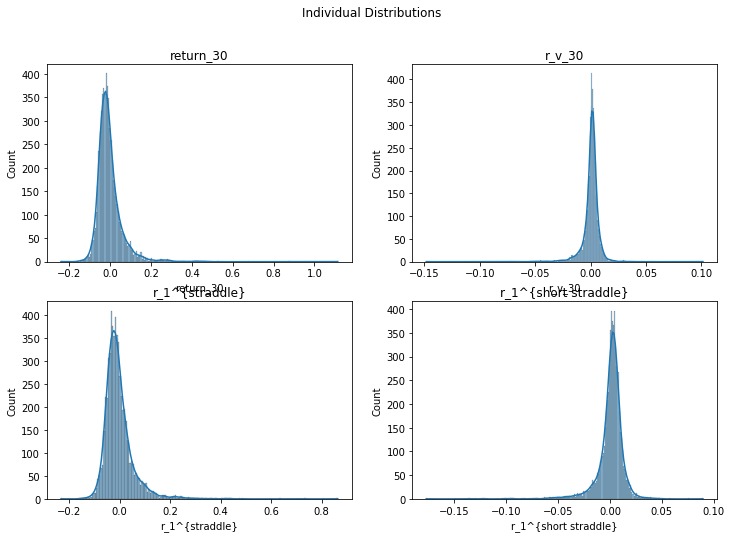

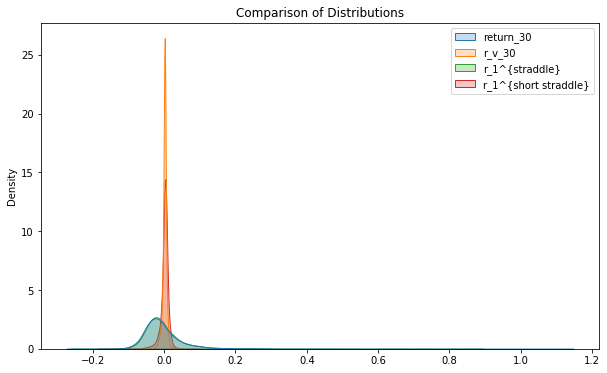

In [40]:
# Assuming compare_InBottomQuintiles is your DataFrame

# List of columns for which you want to create individual plots
columns_to_plot = ['return_30', 'r_v_30', 'r_1^{straddle}', 'r_1^{short straddle}']

# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Individual Distributions')

# Plot individual distributions
for i, col in enumerate(columns_to_plot):
    sns.histplot(compare_InBottomQuintiles[col], kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(col)

# Plot to compare distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(data=compare_InBottomQuintiles[columns_to_plot], fill=True)
plt.title('Comparison of Distributions')

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\_lilliefors.py:272: FutureWarning: The default pvalmethod will change from "approx" to "table" after 0.11. The "table" method uses values from a very large simulation and is more accurate.  Explicitly set this parameter to "approx" or "table" to silence this warning
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\_lilliefors.py:272: FutureWarning: The default pvalmethod will change from "approx" to "table" after 0.11. The "table" method uses values from a very large simulation and is more accurate.  Explicitly set this parameter to "approx" or "table" to silence this warning
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\_lilliefors.py:272: FutureWarning: The default pvalmethod will change from "approx" to "table" after 0.11. The "table" method uses values from a very large simulation and is more accurate.  Explicitly set this p

Descriptive Statistics:
       Custom: Returns long  Custom: Returns short  Author: Returns long  \
count           5908.000000            5908.000000           5908.000000   
mean              -0.003950               0.000461             -0.003216   
std                0.063274               0.007949              0.058947   
min               -0.240796              -0.148267             -0.231530   
25%               -0.039183              -0.001254             -0.036450   
50%               -0.015983               0.001311             -0.014270   
75%                0.014300               0.003614              0.015750   
max                1.114533               0.101376              0.863820   

       Author: Returns short  
count            5908.000000  
mean                0.000615  
std                 0.013086  
min                -0.177220  
25%                -0.002700  
50%                 0.002330  
75%                 0.006640  
max                 0.089770  

Skewness:
C

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\_lilliefors.py:272: FutureWarning: The default pvalmethod will change from "approx" to "table" after 0.11. The "table" method uses values from a very large simulation and is more accurate.  Explicitly set this parameter to "approx" or "table" to silence this warning
  warnings.warn(msg, FutureWarning)


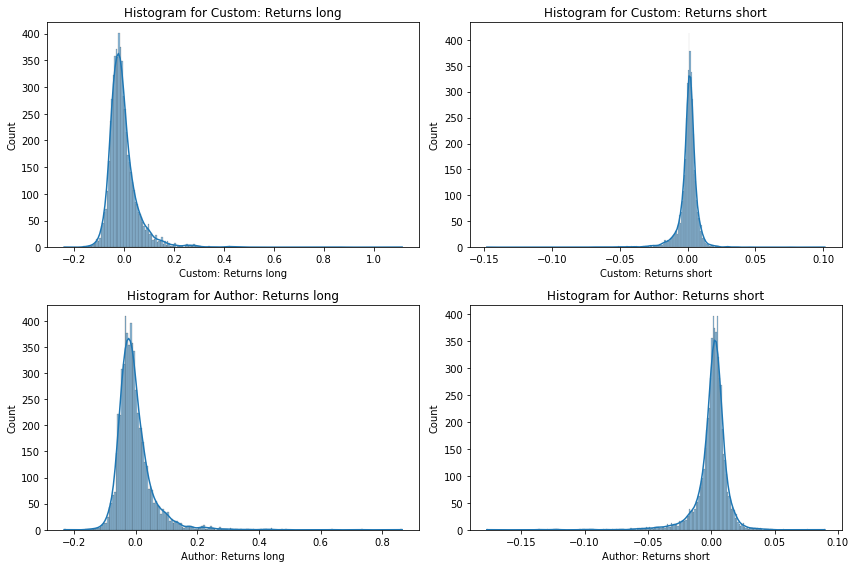

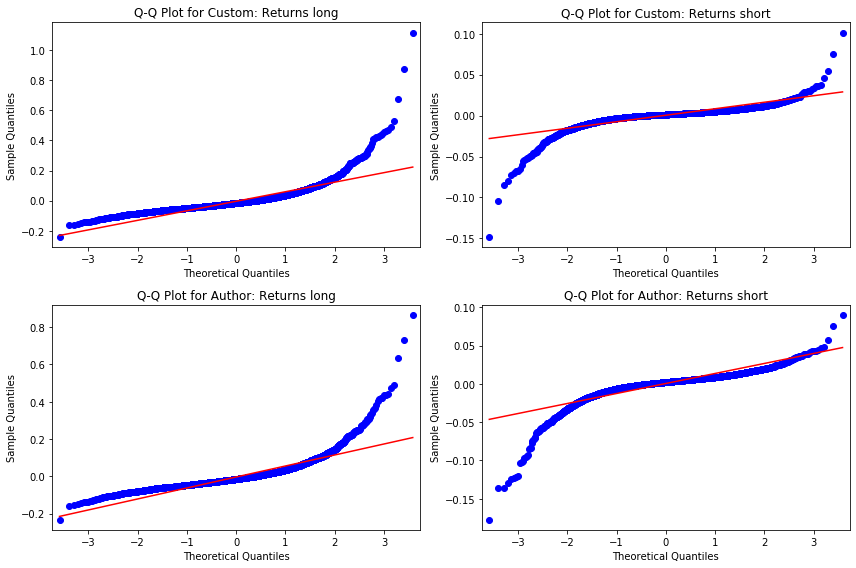

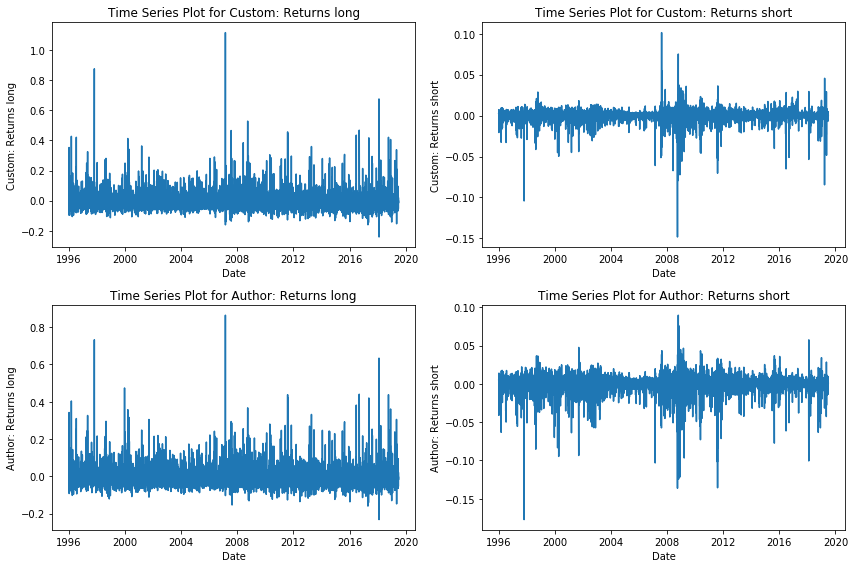

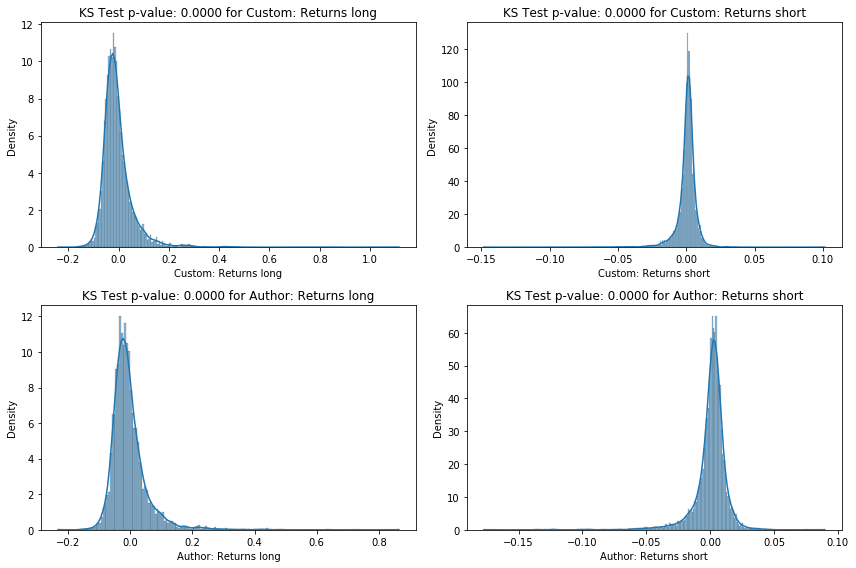

In [41]:
# Assuming compare_InBottomQuintiles is your DataFrame
compare_InBottomQuintiles = compare_InBottomQuintiles.rename(columns={'return_30': 'Custom: Returns long'})
compare_InBottomQuintiles = compare_InBottomQuintiles.rename(columns={'r_v_30': 'Custom: Returns short'})
compare_InBottomQuintiles = compare_InBottomQuintiles.rename(columns={'r_1^{straddle}': 'Author: Returns long'})
compare_InBottomQuintiles = compare_InBottomQuintiles.rename(columns={'r_1^{short straddle}': 'Author: Returns short'})

# List of columns to analyze
columns_to_analyze = ['Custom: Returns long', 'Custom: Returns short', 'Author: Returns long', 'Author: Returns short']

# Descriptive Statistics
summary_stats = compare_InBottomQuintiles[columns_to_analyze].describe()

# Data Visualization
plt.figure(figsize=(12, 8))
for i, col in enumerate(columns_to_analyze, 1):
    plt.subplot(2, 2, i)
    sns.histplot(compare_InBottomQuintiles[col], kde=True)
    plt.title(f'Histogram for {col}')
plt.tight_layout()

# Quantile-Quantile (Q-Q) Plots
plt.figure(figsize=(12, 8))
for i, col in enumerate(columns_to_analyze, 1):
    plt.subplot(2, 2, i)
    qqplot(compare_InBottomQuintiles[col], line='s', ax=plt.gca())
    plt.title(f'Q-Q Plot for {col}')
plt.tight_layout()

# Time Series Plots
# Assuming there's a time-related column, replace 'Date' with the actual time-related column
time_column = 'Date'
if time_column in compare_InBottomQuintiles.columns:
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(columns_to_analyze, 1):
        plt.subplot(2, 2, i)
        sns.lineplot(x=compare_InBottomQuintiles[time_column], y=compare_InBottomQuintiles[col])
        plt.title(f'Time Series Plot for {col}')
    plt.tight_layout()

# Outlier Detection
z_scores = pd.DataFrame({col: zscore(compare_InBottomQuintiles[col]) for col in columns_to_analyze})
outliers = (np.abs(z_scores) > 3).any(axis=1)

# Higher Moments (Skewness and Kurtosis)
skewness = compare_InBottomQuintiles[columns_to_analyze].apply(skew)
kurt = compare_InBottomQuintiles[columns_to_analyze].apply(kurtosis)

# Comparison of Empirical and Theoretical Quantiles
plt.figure(figsize=(12, 8))
for i, col in enumerate(columns_to_analyze, 1):
    plt.subplot(2, 2, i)
    sns.histplot(compare_InBottomQuintiles[col], kde=True, stat='density')
    _, p_value_ks = kstest_normal(compare_InBottomQuintiles[col])
    plt.title(f'KS Test p-value: {p_value_ks:.4f} for {col}')
plt.tight_layout()

# Segmentation Analysis (Example: assuming 'our_condition' is a categorical column for segmentation)
segment_column = 'our_condition'
if segment_column in compare_InBottomQuintiles.columns:
    for segment_value in compare_InBottomQuintiles[segment_column].unique():
        segment_data = compare_InBottomQuintiles[compare_InBottomQuintiles[segment_column] == segment_value]
        # Perform analysis on the segmented data
        # You can reuse the code snippets above with this segmented data

# Display Descriptive Statistics
print("Descriptive Statistics:")
print(summary_stats)

# Display Skewness and Kurtosis
print("\nSkewness:")
print(skewness)
print("\nKurtosis:")
print(kurt)

# Display Outliers
outliers_df = compare_InBottomQuintiles[outliers].copy()
outliers_df['outlier_column'] = outliers_df[columns_to_analyze].apply(lambda x: x.idxmax(), axis=1)
print("\nOutliers:")
print(outliers_df)

# Display Comparison of Empirical and Theoretical Quantiles
for col in columns_to_analyze:
    _, p_value_ks = kstest_normal(compare_InBottomQuintiles[col])
    print(f"\nKS Test p-value for {col}: {p_value_ks:.4f}")

plt.show()

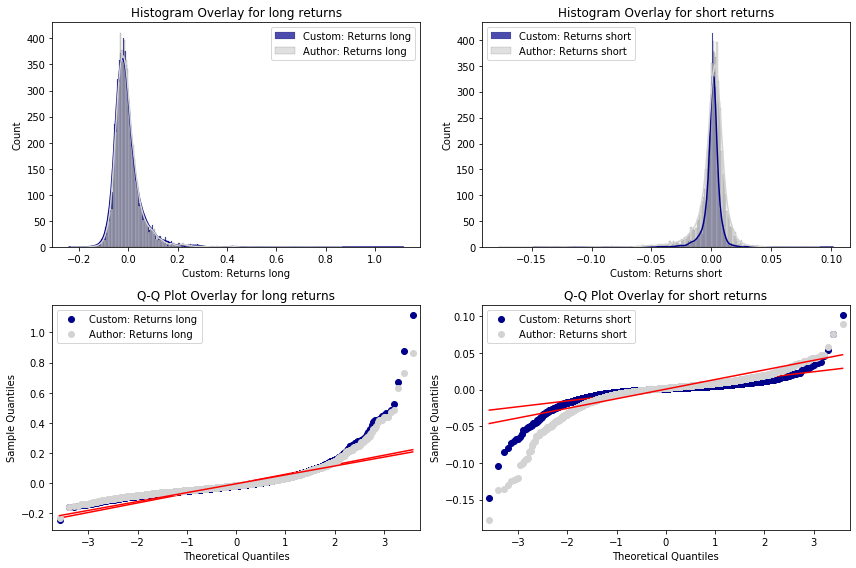

In [42]:
# Data Visualization with Improved Colors
plt.figure(figsize=(12, 8))

# Overlay Histogram for return_30 and r_1^{straddle}
plt.subplot(2, 2, 1)
sns.histplot(compare_InBottomQuintiles['Custom: Returns long'], kde=True, label='Custom: Returns long', color='darkblue', alpha=0.7)
sns.histplot(compare_InBottomQuintiles['Author: Returns long'], kde=True, label='Author: Returns long', color='lightgrey', alpha=0.7)
plt.title('Histogram Overlay for long returns')
plt.legend()

# Overlay Histogram for r_v_30 and r_1^{short straddle}
plt.subplot(2, 2, 2)
sns.histplot(compare_InBottomQuintiles['Custom: Returns short'], kde=True, label='Custom: Returns short', color='darkblue', alpha=0.7)
sns.histplot(compare_InBottomQuintiles['Author: Returns short'], kde=True, label='Author: Returns short', color='lightgrey', alpha=0.7)
plt.title('Histogram Overlay for short returns')
plt.legend()

# Q-Q Plots with Different Colors
plt.subplot(2, 2, 3)
qqplot(compare_InBottomQuintiles['Custom: Returns long'], line='s', ax=plt.gca(), label='Custom: Returns long', color='darkblue')
qqplot(compare_InBottomQuintiles['Author: Returns long'], line='s', ax=plt.gca(), label='Author: Returns long', color='lightgrey')
plt.title('Q-Q Plot Overlay for long returns')
plt.legend()

plt.subplot(2, 2, 4)
qqplot(compare_InBottomQuintiles['Custom: Returns short'], line='s', ax=plt.gca(), label='Custom: Returns short', color='darkblue')
qqplot(compare_InBottomQuintiles['Author: Returns short'], line='s', ax=plt.gca(), label='Author: Returns short', color='lightgrey')
plt.title('Q-Q Plot Overlay for short returns')
plt.legend()

plt.tight_layout()
plt.show()

# Let us do the same for the Autoencoder!

In [143]:
# File paths for the PCA slope data
file_path = 'Data/PCA_custom_AE.csv' #our Autoencoder data

# Reading the CSV files into Pandas DataFrames and only store the column that is needed for the conditional strategy (Slope)
SLOPE_AE = pd.read_csv(file_path)
SLOPE_AE['Date'] = pd.to_datetime(SLOPE_AE['Date'], format='%d/%m/%Y')

In [144]:
SLOPE_AE

,Date,Slope
0,1996-01-04,-1.334184
1,1996-01-05,-1.309369
2,1996-01-08,-1.382568
3,1996-01-09,-1.242809
4,1996-01-10,-1.085744
...,...,...
5907,2019-06-24,-0.586902
5908,2019-06-25,-0.484864
5909,2019-06-26,-0.495315
5910,2019-06-27,-0.541510


In [150]:
# Here, the actual signal is computed
# I get the signal from continously comparing the current value of slope to the historical distribution UP TO t. 
# So in my opinion, there is no need to split up the dataset into training and test data.

# Initialize a list to hold the boolean values for each row
in_bottom_quintile = []

# Calculate quantile based on historical data up until date 't' for each observation
for i in range(len(SLOPE_AE)):
    # Select the data up to the current row's date
    slope_data = SLOPE_AE.loc[SLOPE_AE['Date'] <= SLOPE_AE.iloc[i]['Date']]
    #print(len(slope_data))
    current_value = slope_data.iloc[-1]['Slope']
    #print("Current value: ", current_value)
    historical_values = slope_data.iloc[:-2]['Slope']
    #print("Historical values: ", historical_values)
    quantile = historical_values.quantile(0.05)
    #print('Quantile: ', quantile)
    in_bottom_quintile.append(current_value <= quantile)
     #print(f"True/False_{i}: ", in_bottom_quintile)

# Assign the list to a new column 'InBottomQuintile'
SLOPE_AE['InBottomQuintile'] = in_bottom_quintile

In [151]:
# check how many times the current value is in the bottom quintile
print("    Share of short (false) and long (true) for the bottom quintile")
value_counts = SLOPE_AE['InBottomQuintile'].value_counts()
print(value_counts/sum(value_counts))

    Share of short (false) and long (true) for the bottom quintile
False    0.934878
True     0.065122
Name: InBottomQuintile, dtype: float64


In [152]:
#merge the datasets
returns_long_short_30_5 = pd.merge(returns_long[['Date', 'return_30']], returns_short[['Date','r_v_30']], on='Date', how='inner')
returns_long_short_30_5 = returns_long_short_30_5.merge(SLOPE_AE[['Date', 'InBottomQuintile']], on='Date')
#shift to account for the look ahead bias
returns_long_short_30_5['InBottomQuintile'] = returns_long_short_30_5['InBottomQuintile'].shift(1)
returns_long_short_30_5['InBottomQuintile'][0] = False #set first value manually

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [153]:
# Condition: If the 'InBottomQuintile' is True, use 'return_30' (long return), otherwise 'r_v_30' (short return)
condition = returns_long_short_30_5.apply(lambda row: row['return_30'] if row['InBottomQuintile'] else row['r_v_30'], axis=1)

# Calculate cumulative returns based on the condition
cumulative_return = (1 + condition).cumprod()
returns_long_short_30_5['cumulative_returns'] = cumulative_return
returns_long_short_30_5 # check the result

,Date,return_30,r_v_30,InBottomQuintile,cumulative_returns
0,1996-01-05,-0.047362,0.002855,False,1.002855
1,1996-01-08,-0.050125,0.003020,False,1.005883
2,1996-01-09,0.352578,-0.020640,True,1.360536
3,1996-01-10,0.120899,-0.008543,False,1.348912
4,1996-01-11,-0.096908,0.007298,False,1.358757
...,...,...,...,...,...
5903,2019-06-24,-0.053542,0.003957,False,6.187997
5904,2019-06-25,0.020247,-0.001429,False,6.179152
5905,2019-06-26,-0.035831,0.002890,False,6.197007
5906,2019-06-27,-0.016247,0.001278,False,6.204924


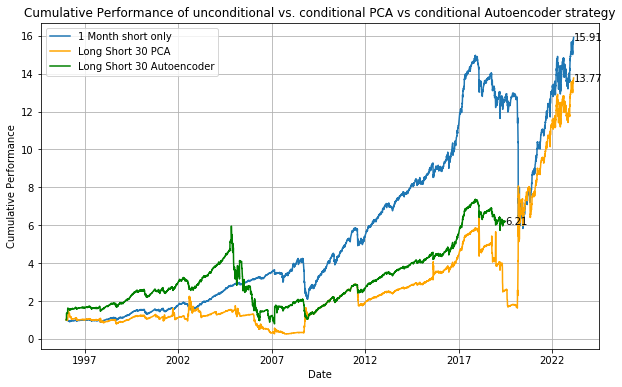

In [154]:
# Plotting the cumulative performances
plt.figure(figsize=(10, 6))

# Plot the cumulative distribution for the unconditional short straddle strategy as a benchmark
plt.plot(returns_short['Date'], returns_short['cumulative_performance_1'], label='1 Month short only')
# Add text annotations for the end value of each line
end_value = returns_short['cumulative_performance_1'].iloc[-1]
plt.text(returns_short['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Add the cumulative returns from the conditional strategy
plt.plot(returns_long_short_30['Date'], returns_long_short_30['cumulative_returns'], color='orange', label='Long Short 30 PCA')
# Add text annotations for the end value of each line
end_value = returns_long_short_30['cumulative_returns'].iloc[-1]
plt.text(returns_long_short_30['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Add the cumulative returns from the conditional strategy
plt.plot(returns_long_short_30_5['Date'], returns_long_short_30_5['cumulative_returns'], color='green', label='Long Short 30 Autoencoder')
# Add text annotations for the end value of each line
end_value = returns_long_short_30_5['cumulative_returns'].iloc[-1]
plt.text(returns_long_short_30_5['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Shade the region where 'InBottomQuantile' is True, so where the two strategies differ
#plt.fill_between(returns_long_short_30['Date'], plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], where=returns_long_short_30['InBottomQuintile'], color='lightgrey', alpha=0.5)

#some formatting
years = pd.date_range(start='1996-01-05', end='2023-02-27', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.title('Cumulative Performance of unconditional vs. conditional PCA vs conditional Autoencoder strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.legend()
plt.grid(True)
# Show the modified plot
plt.show()

## Check which quantile is optimal

In [214]:
# Assuming you have the SLOPE1 and returns_long_short_30_1 DataFrames

# Quantiles to evaluate
quantiles_to_evaluate = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]

# Create a DataFrame to store the results
results_df2 = pd.DataFrame(index=quantiles_to_evaluate, columns=['Cumulative_Returns'])
# Copy the original DataFrame to avoid modifying the original data
returns_long_short_30_5_copy = returns_long_short_30_5.copy()

# Loop through quantiles
for q in quantiles_to_evaluate:
    # Initialize a list to hold the boolean values for each row for the current quantile
    in_bottom_quantile = []

    # Calculate quantile based on historical data up until date 't' for each observation
    for i in range(len(returns_long_short_30_5_copy)):
        # Select the data up to the current row's date
        slope_data = SLOPE_AE.loc[SLOPE_AE['Date'] <= SLOPE_AE.iloc[i]['Date']]
        current_value = slope_data.iloc[-1]['Slope']
        historical_values = slope_data.iloc[:-2]['Slope']
        quantile_value = historical_values.quantile(q)
        in_bottom_quantile.append(current_value <= quantile_value)
        
    # Assign the list to a new column
    returns_long_short_30_5_copy[f'InBottomQuantile_{q}'] = in_bottom_quantile

    # Shift to account for the look ahead bias
    returns_long_short_30_5_copy[f'InBottomQuantile_{q}'] = returns_long_short_30_5_copy[f'InBottomQuantile_{q}'].shift(1)
    returns_long_short_30_5_copy.loc[0, f'InBottomQuantile_{q}'] = False

    # Calculate cumulative returns based on the condition
    cumulative_return = (1 + returns_long_short_30_5_copy.apply(lambda row: row['return_30'] if row[f'InBottomQuantile_{q}'] else row['r_v_30'], axis=1)).cumprod().iloc[-1]

    # Store the results in the DataFrame
    results_df2.at[q, 'Cumulative_Returns'] = cumulative_return


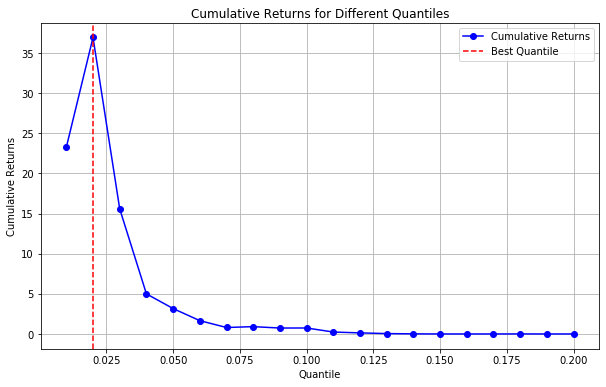

Best quantile to use: 0.02


In [215]:
# Find the quantile with the maximum cumulative returns
max_return = results_df2['Cumulative_Returns'].max()
best_quantile = results_df2.loc[results_df2['Cumulative_Returns'] == max_return].index[0]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results_df2.index, results_df2['Cumulative_Returns'], marker='o', linestyle='-', color='blue', label='Cumulative Returns')
plt.axvline(x=best_quantile, color='red', linestyle='--', label='Best Quantile')

# Customize the plot
plt.title('Cumulative Returns for Different Quantiles')
plt.xlabel('Quantile')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

print(f"Best quantile to use: {best_quantile}")

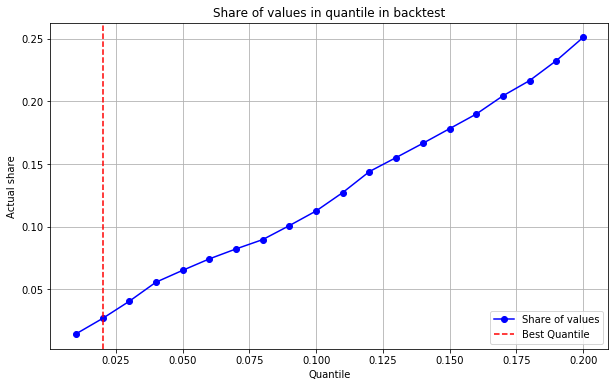

In [216]:
# Calculate the share of True values per quantile and store in 'True_Share' column
results_df2['True_Share'] = [returns_long_short_30_5_copy[f'InBottomQuantile_{q}'].mean() for q in quantiles_to_evaluate]
# Find the quantile with the maximum cumulative returns
max_return = results_df2['Cumulative_Returns'].max()
best_quantile = results_df2.loc[results_df2['Cumulative_Returns'] == max_return].index[0]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results_df2.index, results_df2['True_Share'], marker='o', linestyle='-', color='blue', label='Share of values')
plt.axvline(x=best_quantile, color='red', linestyle='--', label='Best Quantile')

# Customize the plot
plt.title('Share of values in quantile in backtest')
plt.xlabel('Quantile')
plt.ylabel('Actual share')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [219]:
results_df

,Cumulative_Returns,True_Share
0.01,112.18,0.015813
0.02,147.927,0.021816
0.03,167.013,0.026501
0.04,322.418,0.029136
0.05,290.849,0.032504
0.06,239.086,0.034993
0.07,189.408,0.037189
0.08,256.53,0.039678
0.09,270.565,0.045534
0.10,213.783,0.049634


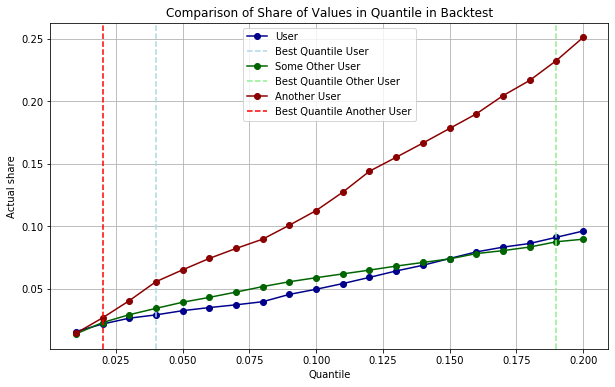

In [222]:
# Find the best quantile for each DataFrame
# Find the quantile with the maximum cumulative returns
max_return = results_df['Cumulative_Returns'].max()
best_quantile = results_df.loc[results_df['Cumulative_Returns'] == max_return].index[0]
# Find the quantile with the maximum cumulative returns
max_return = results_df1['Cumulative_Returns'].max()
best_quantile1 = results_df1.loc[results_df1['Cumulative_Returns'] == max_return].index[0]
# Find the quantile with the maximum cumulative returns
max_return = results_df2['Cumulative_Returns'].max()
best_quantile2 = results_df2.loc[results_df2['Cumulative_Returns'] == max_return].index[0]

# Plotting
plt.figure(figsize=(10, 6))

# Plot for results_df
plt.plot(results_df.index, results_df['True_Share'], marker='o', linestyle='-', color='darkblue', label='User')
plt.axvline(x=best_quantile, color='lightblue', linestyle='--', label='Best Quantile User')

# Plot for results_df1
plt.plot(results_df1.index, results_df1['True_Share'], marker='o', linestyle='-', color='darkgreen', label='Some Other User')
plt.axvline(x=best_quantile1, color='lightgreen', linestyle='--', label='Best Quantile Other User')

# Plot for results_df2
plt.plot(results_df2.index, results_df2['True_Share'], marker='o', linestyle='-', color='darkred', label='Another User')
plt.axvline(x=best_quantile2, color='red', linestyle='--', label='Best Quantile Another User')

# Customize the plot
plt.title('Comparison of Share of Values in Quantile in Backtest')
plt.xlabel('Quantile')
plt.ylabel('Actual share')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# To do
- create plot to compare optimal quantiles with each other: autoencoder, PCA author, PCA from us.
PCA author needs to be checked, values will be much lower because it only goes until 2019
- one more plot where the backtesting is visualized, share we go long at the different quanitles against quantiles.